# Predictive Modeling for Insurance Claims

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Exploration and Preprocessing 

* Load the Training Dataset which is made up of 7160 records and 14 features. 
* No duplicates identified. 
* The following columns: 'garden', 'building_dimension', 'date_of_occupancy', 'geo_code' are identified to have missing values of 7, 106, 508, 102 respectively. 
* Unified columns to lowercase for easy use. 
* NumberOfWindows feature contained values that are not numeric and contained the string '.', this was first replaced with NaN and then replaced with the median.
* A summary of statistics includes but not limited to: the mean as 2013.670, the median as 2013.000, the standard deviation as 1.384. 
* The distribution of the data is visaulized using a histogram and this indicated a positively skewed distribution and thus missing values of the numerical varibales were filled by the median since the median is less senstive to extreme values compared to the mean. 
* Exploring the distribution of the target varibale(claim) indicates that about 22.8% of the buildings have atleast one claim over insured period. 
* Categorical columns (building_painted, building_fenced, garden, settlement) were encoded using label encoding
* Visualizations of the independent variables vs the dependent variable: Categorical columns vs claim are visualized using bar plots, and Numerical columns vs claim are visualized using box plot.
* During feature selection, building_fenced was dropped since it is highy correlated with settlement, geo_code was dropped since it was less relevant to the target variable.

In [2]:
#Loading the Training Dataset

df_train = pd.read_csv("C:/Users/HP/Zoomcamp/Datasets/train_data.csv")
df_train

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.000000,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.000000,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.000000,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.000000,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.000000,0,V,N,O,R,680.0,1,1800.0,3,1053,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7155,H5290,2012,1.000000,1,V,V,V,U,NaN,1,2001.0,.,NaN,0
7156,H5926,2013,1.000000,0,V,V,V,U,NaN,2,1980.0,.,NaN,1
7157,H6204,2016,0.038251,0,V,V,V,U,NaN,1,1992.0,.,NaN,0
7158,H6537,2013,1.000000,0,V,V,V,U,NaN,1,1972.0,.,NaN,0


In [3]:
# Checking for Duplicates
print(df_train.duplicated().value_counts())
df_train.drop_duplicates(inplace = True)
print(len(df_train))

False    7160
dtype: int64
7160


In [4]:
# Viewing all coulmns as rows
df_train.head().T

,0,1,2,3,4
Customer Id,H14663,H2037,H3802,H3834,H5053
YearOfObservation,2013,2015,2014,2013,2014
Insured_Period,1.0,1.0,1.0,1.0,1.0
Residential,0,0,0,0,0
Building_Painted,N,V,N,V,V
Building_Fenced,V,N,V,V,N
Garden,V,O,V,V,O
Settlement,U,R,U,U,R
Building Dimension,290.0,490.0,595.0,2840.0,680.0
Building_Type,1,1,1,1,1


In [5]:
# Making columns uniform by changing all of them to lowercase

df_train.columns = df_train.columns.str.lower().str.replace(' ', '_')

string_columns = list(df_train.dtypes[df_train.dtypes == 'object'].index)

for col in string_columns:
    df_train[col] = df_train[col].str.lower().str.replace(' ', '_')

In [6]:
# Converting the values in the numberofwindows column that are not numeric and... 
#...contain the string '.' and replacing them with the median.

df_train['numberofwindows'] = pd.to_numeric(df_train['numberofwindows'], errors='coerce')

# Calculating the median value (ignoring NaN)
median_value = round(df_train['numberofwindows'].median(skipna=True))

# Replaceing NaN values with the median
df_train['numberofwindows'].fillna(median_value, inplace=True)

# Converting the column to an integer
df_train['numberofwindows'] = df_train['numberofwindows'].astype(int)

In [7]:
# Summary of statistics

df_train.describe().round(3)

,yearofobservation,insured_period,residential,building_dimension,building_type,date_of_occupancy,numberofwindows,claim
count,7160.000,7160.000,7160.000,7054.000,7160.000,6652.000,7160.000,7160.000
mean,2013.670,0.910,0.305,1883.728,2.186,1964.456,4.111,0.228
std,1.384,0.240,0.461,2278.158,0.941,36.002,1.166,0.420
min,2012.000,0.000,0.000,1.000,1.000,1545.000,1.000,0.000
25%,2012.000,0.997,0.000,528.000,2.000,1960.000,4.000,0.000
50%,2013.000,1.000,0.000,1083.000,2.000,1970.000,4.000,0.000
75%,2015.000,1.000,1.000,2289.750,3.000,1980.000,4.000,0.000
max,2016.000,1.000,1.000,20940.000,4.000,2016.000,9.000,1.000


In [8]:
# Matching columns with their respective datatypes

columns_datatype = list(zip(df_train.columns, column_datatype))
columns_datatype

NameError: name 'column_datatype' is not defined

In [ ]:
# Finding columns with missing values

columns_with_missing_values = df_train.columns[df_train.isna().any()]
columns_with_missing_values

In [9]:
# Finding the sum of missing values in each columns

df_train.isnull().sum()

customer_id             0
yearofobservation       0
insured_period          0
residential             0
building_painted        0
building_fenced         0
garden                  7
settlement              0
building_dimension    106
building_type           0
date_of_occupancy     508
numberofwindows         0
geo_code              102
claim                   0
dtype: int64

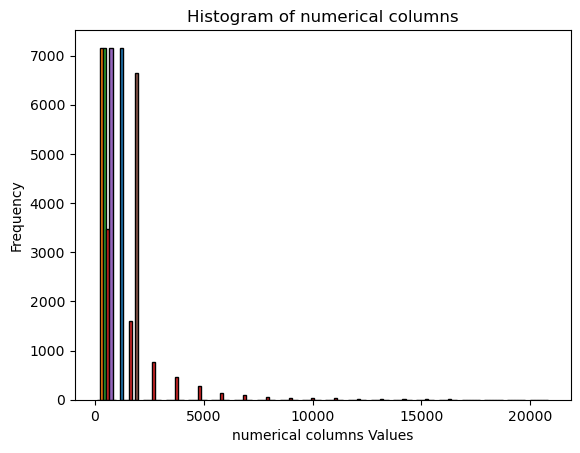

In [10]:
# Visualizing the distribution of the data using a histogram

numerical_columns = ['yearofobservation', 'insured_period', 'residential', 
            'building_dimension', 'building_type', 'date_of_occupancy']

# Plotting a histogram
plt.hist(df_train[numerical_columns], bins=20, edgecolor='black')
plt.title('Histogram of numerical columns')
plt.xlabel('numerical columns Values')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Handling Missing Values
# Using median since the distribution of the data is positively skewed

df_train['garden'].fillna('U', inplace=True)

df_train['building_dimension'].fillna(df_train['building_dimension'].median(), inplace=True)

df_train['date_of_occupancy'].fillna(df_train['date_of_occupancy'].median(), inplace=True)

df_train['geo_code'].fillna('U', inplace=True)

In [12]:
df_train.head().T

,0,1,2,3,4
customer_id,h14663,h2037,h3802,h3834,h5053
yearofobservation,2013,2015,2014,2013,2014
insured_period,1.0,1.0,1.0,1.0,1.0
residential,0,0,0,0,0
building_painted,n,v,n,v,v
building_fenced,v,n,v,v,n
garden,v,o,v,v,o
settlement,u,r,u,u,r
building_dimension,290.0,490.0,595.0,2840.0,680.0
building_type,1,1,1,1,1


In [13]:
# Exploring the distribution of the target variable

df_train['claim'].value_counts()

0    5526
1    1634
Name: claim, dtype: int64

In [14]:
# Getting the percentage of the count (Claim Rate)

df_train.claim.value_counts(normalize=True)

0    0.771788
1    0.228212
Name: claim, dtype: float64

### Encoding Categorical variables

* settlement (1 - Rural Areas(R), 0 - Urban Areas(U))
* garden (1 - has garden(V), 0 - no garden(O))
* building_fenced (1 - fenced(N), 0 - not fenced(V))
* building_painted (1 - painted(N), 0 - not painted(V))

In [15]:
categorical_columns = ['building_painted', 'building_fenced', 'garden', 'settlement']

In [16]:
df_train['garden'] = df_train['garden'].apply(lambda x: 1 if x == 'v' else 0)

In [17]:
df_train['settlement'] = df_train['settlement'].apply(lambda x: 1 if x == 'r' else 0)

In [18]:
df_train['building_fenced'] = df_train['building_fenced'].apply(lambda x: 1 if x == 'n' else 0)

In [19]:
df_train['building_painted'] = df_train['building_painted'].apply(lambda x: 1 if x == 'n' else 0)

In [20]:
df_train.head().T

,0,1,2,3,4
customer_id,h14663,h2037,h3802,h3834,h5053
yearofobservation,2013,2015,2014,2013,2014
insured_period,1.0,1.0,1.0,1.0,1.0
residential,0,0,0,0,0
building_painted,1,0,1,0,0
building_fenced,0,1,0,0,1
garden,1,0,1,1,0
settlement,0,1,0,0,1
building_dimension,290.0,490.0,595.0,2840.0,680.0
building_type,1,1,1,1,1


### Visualizing independent variables vs dependent variable

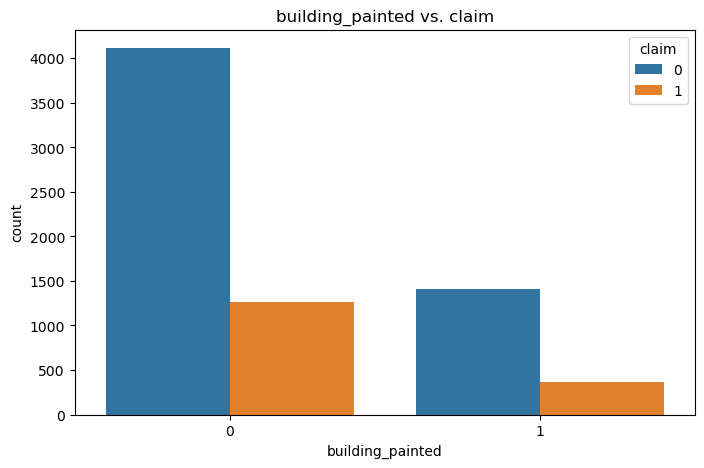

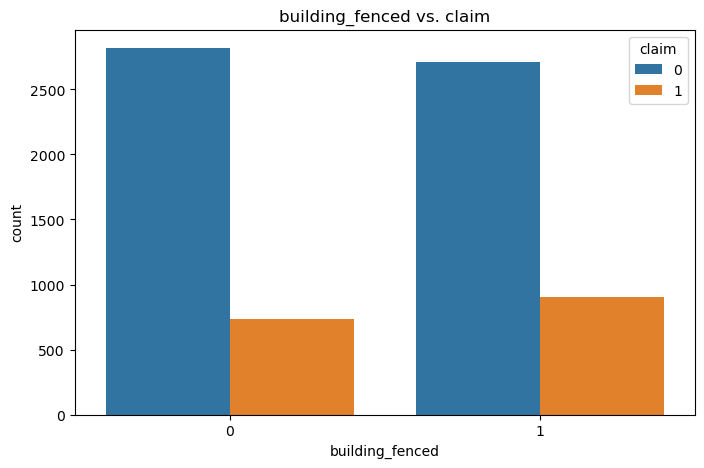

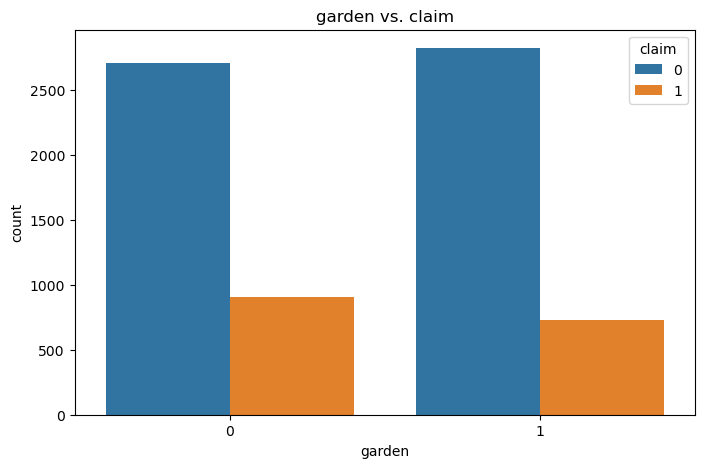

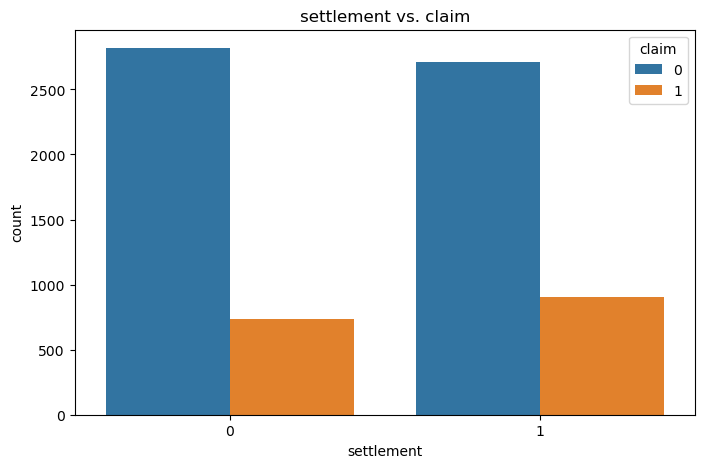

In [21]:
for column in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=column, hue='claim', data=df_train)
    plt.title(f'{column} vs. claim')
    plt.show()

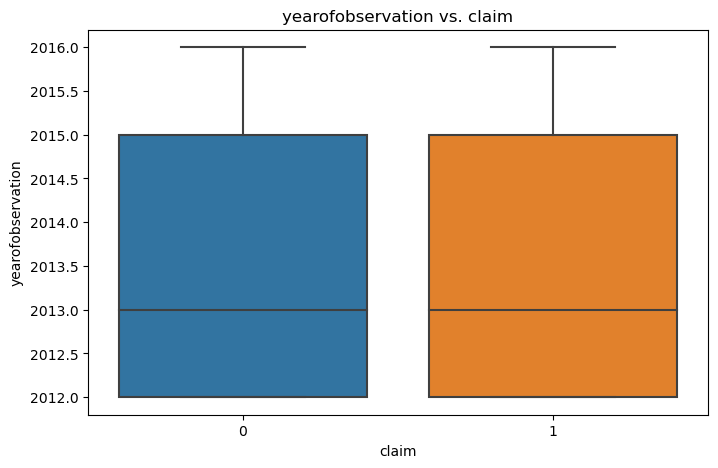

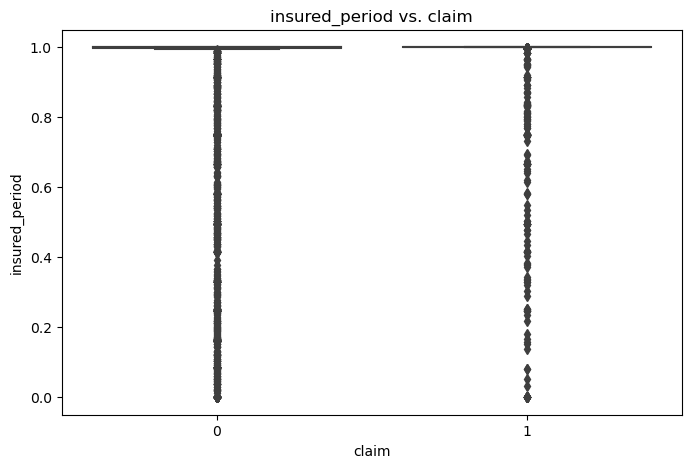

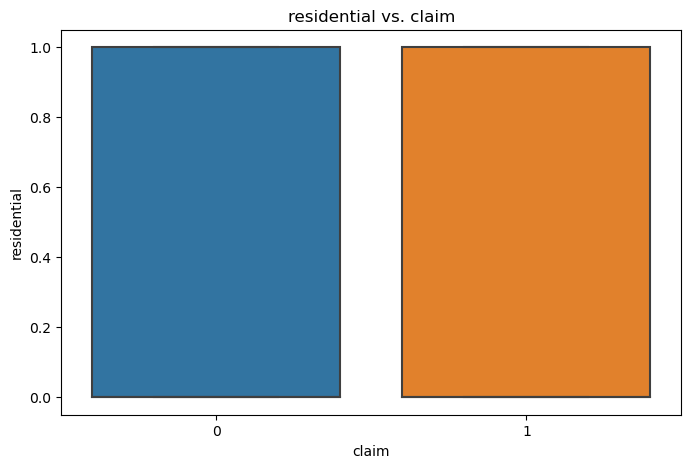

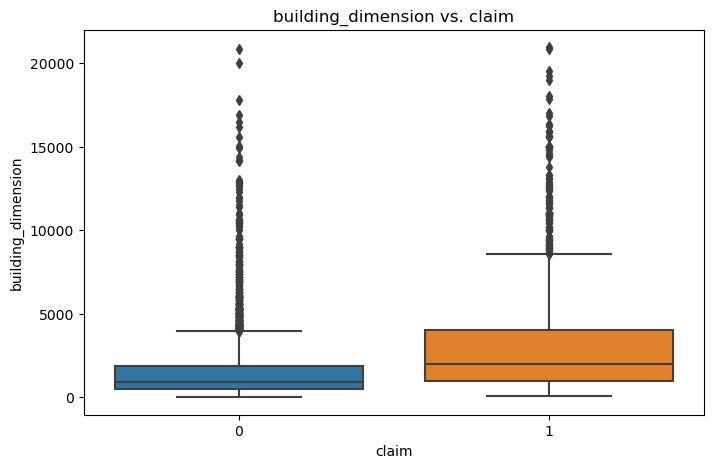

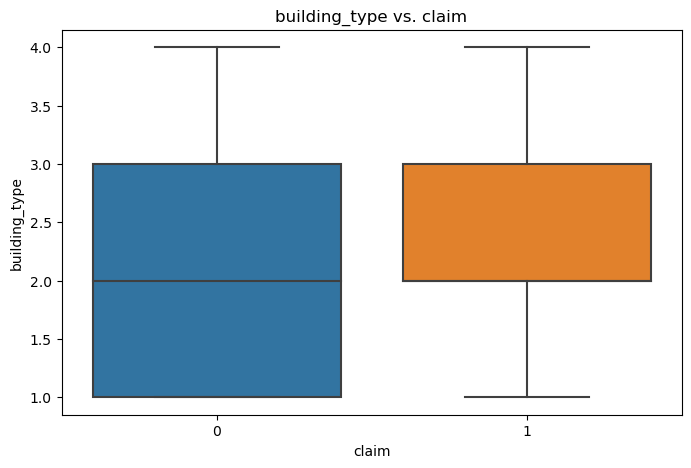

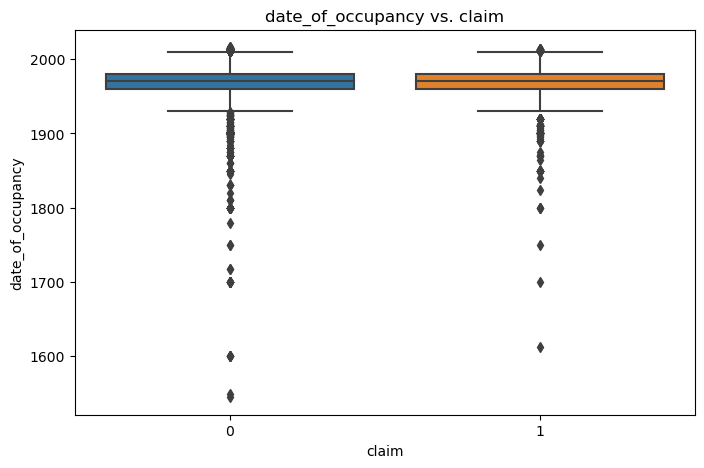

In [22]:
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='claim', y=column, data=df_train)
    plt.title(f'{column} vs. claim')
    plt.show()

## Feature Selection

Correlation is often used in machine learning to identify multicollinearity, which is when two or more predictor variables are highly correlated with each other. Multicollinearity can impact the accuracy of predictive models and thus building_fenced was dropped since it was highy correlated with settlement.

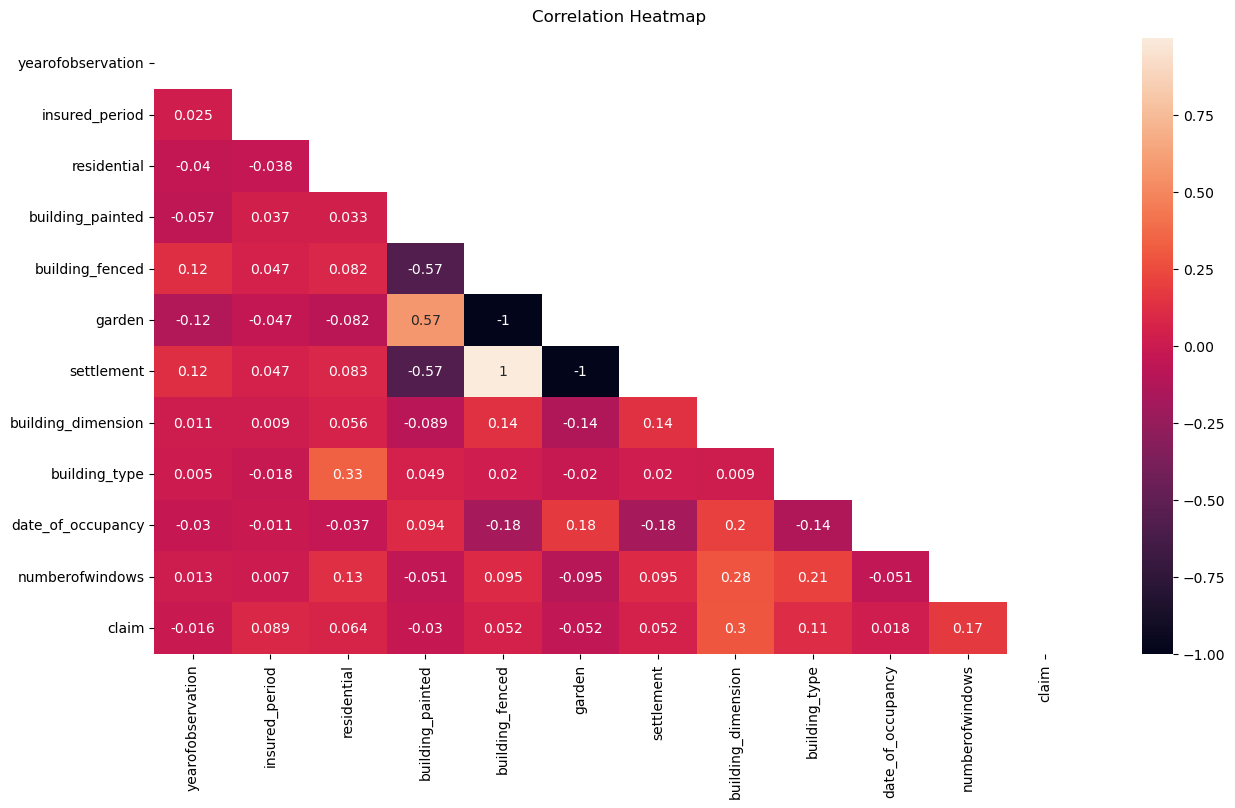

In [23]:
plt.figure(figsize=(15, 8))

mask = np.triu(np.ones_like(df_train.corr(), dtype=bool))
heatmap = sns.heatmap(df_train.corr().round(3),mask=mask, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

plt.show()

In [24]:
# Dropping building_fenced since it is highly correlated with settlement

del df_train['building_fenced']

# Dropping the geo_code feature

del df_train['geo_code']

### Model Building

* In this section, the testing dataset was loaded which contains 3069 records and 13 features.
* Since the training dataset did not have the target variable, the training dataset was further split into a smaller training set (X_train, y_train) and a validation set (X_val, y_val).
* The model is thus trained on X_train and y_train and evaluate its performance on the validation set (X_val, y_val).
* The model was built using SVM, KNN, Naive Bayes, and Linear Regression alogorithms.
* Evaluating the model using SVM Alogirthm on the validation dataset resulted into a score of 0.78, and an AUC score of 0.58.
* Evaluating the model using KNN Alogirthm when k = 3 on the validation dataset resulted into a score of 0.73, and an AUC score of 0.60.
* Evaluating the model using KNN Alogirthm when k = 5 on the validation dataset resulted into a score of 0.74, and an AUC score of 0.61.
* Evaluating the model using Naive Bayes Alogirthm on the validation dataset resulted into a score of 0.70, and an AUC score of 0.67.

In [26]:
X_train = df_train.drop('claim', axis=1)
y_train = df_train['claim']

#### Support Vector Machine

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [28]:
from sklearn.svm import SVC

model = SVC(probability=True)

In [29]:
# Dropping the customer_id column

X_train = X_train.drop('customer_id', axis=1)
X_val = X_val.drop('customer_id', axis=1)

In [30]:
model.fit(X_train, y_train)

SVC(probability=True)

In [31]:
X_train.iloc[:5]

,yearofobservation,insured_period,residential,building_painted,garden,settlement,building_dimension,building_type,date_of_occupancy,numberofwindows
5266,2016,0.997268,1,1,1,0,850.0,4,1960.0,4
5441,2015,1.000000,0,1,1,0,2135.0,2,1960.0,4
7025,2013,1.000000,0,0,0,1,2700.0,3,1970.0,6
7130,2014,1.000000,1,0,1,0,1083.0,1,1700.0,4
4454,2013,1.000000,0,0,0,1,1080.0,2,1960.0,5


In [32]:
model.score(X_val, y_val)

0.7730446927374302

#### K-Nearest Neighbor(KNN) Algorithm

In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)

In [34]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [35]:
knn.score(X_val, y_val)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.7311452513966481

#### Using k = 5

In [36]:
knn_test = KNeighborsClassifier(n_neighbors = 5)

In [37]:
knn_test.fit(X_train, y_train)

KNeighborsClassifier()

In [38]:
knn_test.score(X_val, y_val)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.7458100558659218

In [181]:
knn_test = KNeighborsClassifier(n_neighbors = 10)
knn_test.fit(X_train, y_train)
knn_test.score(X_val, y_val)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.7660614525139665

#### 3) Naye Bayes Algorithm

In [39]:
from sklearn.naive_bayes import MultinomialNB

In [40]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [41]:
nb_model.score(X_val, y_val)

0.7046089385474861

#### 4) Linear Regression Algorithm

In [42]:
from sklearn import linear_model

In [43]:
reg = linear_model.LinearRegression()

In [44]:
reg.fit(X_train, y_train)

LinearRegression()

In [62]:
reg.score(X_val, y_val)

0.11435808662560931

### Model Evaluation

In [46]:
from sklearn.metrics import roc_auc_score

from sklearn import metrics

from sklearn.metrics import roc_curve

#### 1) Support Vector Algorithm

In [47]:
y_pred_prob = model.predict_proba(X_val)[:, 1]

In [48]:
auc_score_svm = roc_auc_score(y_val, y_pred_prob)
print("AUC Score:", auc_score_svm)

AUC Score: 0.5788886707459397


In [49]:
# Confusion matrix

# Assuming y_pred_prob is a column of probability scores
y_pred = (y_pred_prob >= 0.5).astype(int)

conf_matrix = metrics.confusion_matrix(y_val, y_pred)

print(conf_matrix)

[[1078   20]
 [ 305   29]]


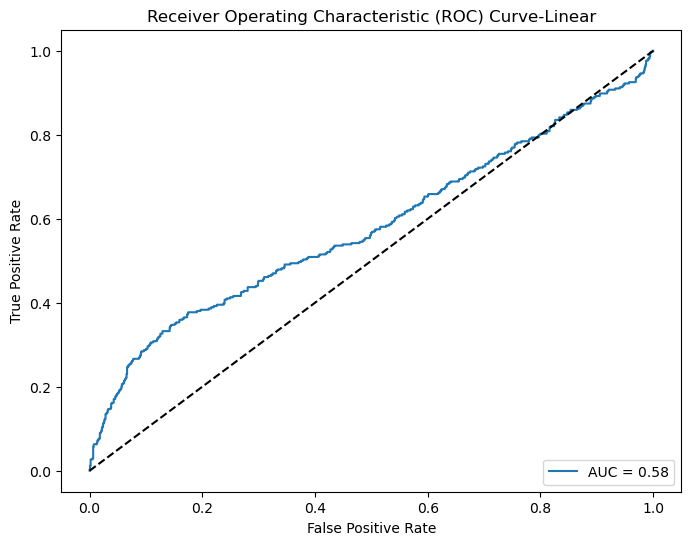

In [50]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score_svm:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve-Linear')
plt.legend(loc='lower right')
plt.show()

#### 2) KNN Algorithm

In [51]:
y_pred_prob_knn = knn.predict_proba(X_val)[:, 1]

In [52]:
auc_score_knn = roc_auc_score(y_val, y_pred_prob_knn)
print("AUC Score:", auc_score_knn)

AUC Score: 0.6047617878996105


In [53]:
# Confusion matrix

# Assuming y_pred_prob is a column of probability scores
y_pred_knn = (y_pred_prob_knn >= 0.5).astype(int)

conf_matrix = metrics.confusion_matrix(y_val, y_pred_knn)

print(conf_matrix)

[[961 137]
 [248  86]]


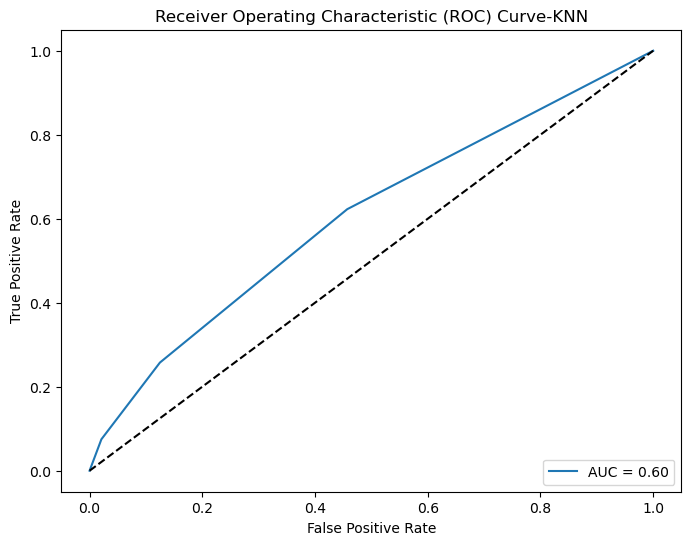

In [54]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score_knn:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve-KNN')
plt.legend(loc='lower right')
plt.show()

#### Evaliuating KNN Model when k=5

In [55]:
y_pred_prob_knn_test = knn_test.predict_proba(X_val)[:, 1]

In [56]:
auc_score_knn_test = roc_auc_score(y_val, y_pred_prob_knn_test)
print("AUC Score:", auc_score_knn_test)

AUC Score: 0.6163369981348779


In [57]:
# Confusion matrix

# Assuming y_pred_prob is a column of probability scores
y_pred_knn_test = (y_pred_prob_knn_test >= 0.5).astype(int)

conf_matrix = metrics.confusion_matrix(y_val, y_pred_knn_test)

print(conf_matrix)

[[992 106]
 [258  76]]


#### 3) Naive Bayes

In [58]:
y_pred_prob_nb = nb_model.predict_proba(X_val)[:, 1]

In [59]:
auc_score_nb = roc_auc_score(y_val, y_pred_prob_nb)
print("AUC Score:", auc_score_nb)

AUC Score: 0.6689653479925396


In [60]:
# Confusion matrix

# Assuming y_pred_prob is a column of probability scores
y_pred_nb = (y_pred_prob_nb >= 0.5).astype(int)

conf_matrix = metrics.confusion_matrix(y_val, y_pred_nb)

print(conf_matrix)

[[858 240]
 [183 151]]


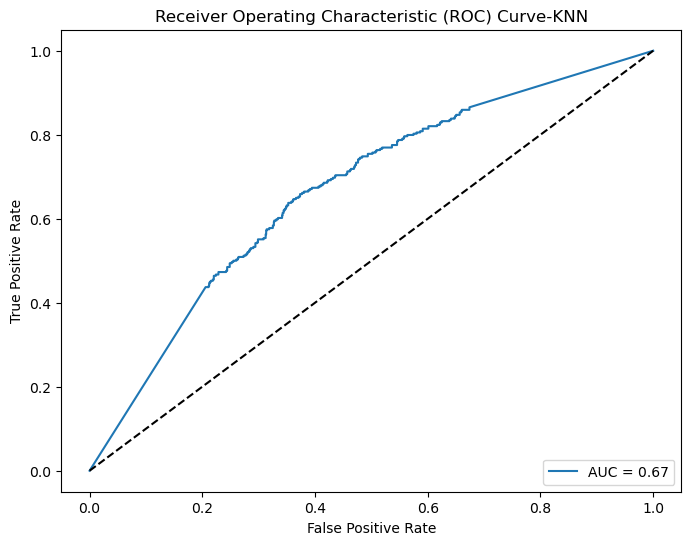

In [61]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_nb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score_nb:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve-KNN')
plt.legend(loc='lower right')
plt.show()

### Making predictions to the test dataset

* The dataset was first transformed so as to match with the training dataset, i.e change the feature variables to lowercase, handle missing values, delete the features that were deleted during training

In [301]:
# Loading the Testing Dataset

df_test = pd.read_csv("C:/Users/HP/Zoomcamp/Datasets/test_data.csv")
df_test

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,H11583,2015,1.000000,0,V,V,V,U,NaN,4,1900.0,.,NaN
3065,H11720,2012,1.000000,0,V,V,V,U,NaN,2,1948.0,.,NaN
3066,H11721,2012,1.000000,0,V,V,V,U,NaN,2,1993.0,.,NaN
3067,H12408,2013,1.000000,0,V,V,V,U,NaN,1,1800.0,.,NaN


In [302]:
# Making columns uniform by changing all of them to lowercase

df_test.columns = df_test.columns.str.lower().str.replace(' ', '_')

String_columns = list(df_test.dtypes[df_test.dtypes == 'object'].index)

for col in string_columns:
    df_test[col] = df_test[col].str.lower().str.replace(' ', '_')

In [303]:
df_test.head().T

,0,1,2,3,4
customer_id,h11920,h11921,h9805,h7493,h7494
yearofobservation,2013,2016,2013,2014,2016
insured_period,1.0,0.997268,0.369863,1.0,1.0
residential,0,0,0,0,0
building_painted,v,v,v,v,v
building_fenced,n,n,v,n,n
garden,o,o,v,o,o
settlement,r,r,u,r,r
building_dimension,300.0,300.0,790.0,1405.0,1405.0
building_type,1,1,1,1,1


In [304]:
df_customer_id = df_test['customer_id']
df_customer_id = df_customer_id.reset_index(name='customer_id')
del df_customer_id['index']
df_customer_id.head().T

,0,1,2,3,4
customer_id,h11920,h11921,h9805,h7493,h7494


In [305]:
del df_test['customer_id']
del df_test['geo_code']

In [306]:
# Converting the values in the numberofwindows column that are not numeric and... 
#...contain the string '.' and replacing them with the median.

df_test['numberofwindows'] = pd.to_numeric(df_test['numberofwindows'], errors='coerce')

# Calculating the median value (ignoring NaN)
median_value = round(df_test['numberofwindows'].median(skipna=True))

# Replaceing NaN values with the median
df_test['numberofwindows'].fillna(median_value, inplace=True)

# Converting the column to an integer
df_test['numberofwindows'] = df_test['numberofwindows'].astype(int)

In [307]:
df_test.isnull().sum()

yearofobservation       0
insured_period          0
residential             0
building_painted        0
building_fenced         0
garden                  4
settlement              0
building_dimension     13
building_type           0
date_of_occupancy     728
numberofwindows         0
dtype: int64

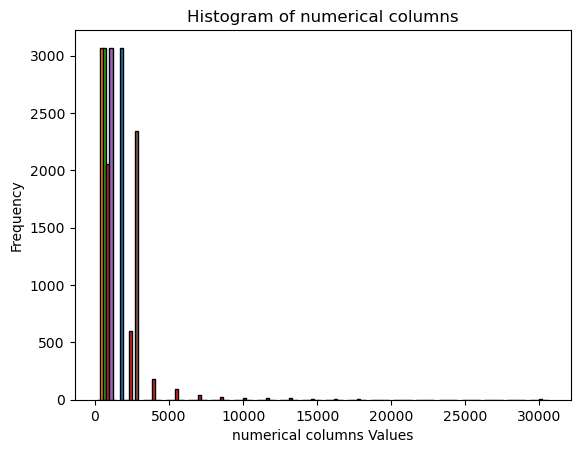

In [308]:
# Visualizing the distribution of the test data using a histogram

numerical_columns = ['yearofobservation', 'insured_period', 'residential', 
            'building_dimension', 'building_type', 'date_of_occupancy']

# Plotting a histogram
plt.hist(df_test[numerical_columns], bins=20, edgecolor='black')
plt.title('Histogram of numerical columns')
plt.xlabel('numerical columns Values')
plt.ylabel('Frequency')
plt.show()

In [309]:
df_test['building_dimension'].fillna(df_test['building_dimension'].median(), inplace=True)

df_test['date_of_occupancy'].fillna(df_test['date_of_occupancy'].median(), inplace=True)

In [310]:
df_test['garden'] = df_test['garden'].apply(lambda x: 1 if x == 'v' else 0)

df_test['settlement'] = df_test['settlement'].apply(lambda x: 1 if x == 'r' else 0)

df_test['building_fenced'] = df_test['building_fenced'].apply(lambda x: 1 if x == 'n' else 0)

df_test['building_painted'] = df_test['building_painted'].apply(lambda x: 1 if x == 'n' else 0)

In [311]:
del df_test['building_fenced']

#### Using the SVM Algorithm to make predictions on the Test Dataset

In [312]:
p = model.predict(df_test)

In [313]:
df_test['claims'] = p
df_test.head().T

,0,1,2,3,4
yearofobservation,2013.0,2016.000000,2013.000000,2014.0,2016.0
insured_period,1.0,0.997268,0.369863,1.0,1.0
residential,0.0,0.000000,0.000000,0.0,0.0
building_painted,0.0,0.000000,0.000000,0.0,0.0
garden,0.0,0.000000,1.000000,0.0,0.0
settlement,1.0,1.000000,0.000000,1.0,1.0
building_dimension,300.0,300.000000,790.000000,1405.0,1405.0
building_type,1.0,1.000000,1.000000,1.0,1.0
date_of_occupancy,1960.0,1960.000000,1960.000000,2004.0,2004.0
numberofwindows,3.0,3.000000,4.000000,3.0,3.0


In [314]:
df_test = pd.concat([df_test, df_customer_id['customer_id']], axis=1)

In [315]:
# df_test.drop('yearofobservation', 'insured_period', 'residential', 'date_of_occupancy', 'numberofwindows'
#         'building_painted', 'garden', 'settlement', 'building_dimension', 'building_type')

In [316]:
# Exporting the dataframe to a new csv

df_test.to_csv("SVM Submission.csv", index=False)

#### Using Naive Bayes Algorithm to make predictions on the Test Dataset

In [297]:
data = nb_model.predict(df_test)

In [298]:
df_test['claims'] = data
df_test.head().T

,0,1,2,3,4
yearofobservation,2013.0,2016.000000,2013.000000,2014.0,2016.0
insured_period,1.0,0.997268,0.369863,1.0,1.0
residential,0.0,0.000000,0.000000,0.0,0.0
building_painted,0.0,0.000000,0.000000,0.0,0.0
garden,0.0,0.000000,1.000000,0.0,0.0
settlement,1.0,1.000000,0.000000,1.0,1.0
building_dimension,300.0,300.000000,790.000000,1405.0,1405.0
building_type,1.0,1.000000,1.000000,1.0,1.0
date_of_occupancy,1960.0,1960.000000,1960.000000,2004.0,2004.0
numberofwindows,3.0,3.000000,4.000000,3.0,3.0


In [299]:
df_test = pd.concat([df_test, df_customer_id['customer_id']], axis=1)

In [300]:
# Exporting the dataframe to a new csv

df_test.to_csv("Naive Bayes Submission.csv", index=False)

#### Using KNN Algorithm to make predictions on the Test Dataset

In [263]:
KNN_data = knn.predict(df_test)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [266]:
df_test['claims'] = KNN_data
df_test.head().T

,0,1,2,3,4
yearofobservation,2013.0,2016.000000,2013.000000,2014.0,2016.0
insured_period,1.0,0.997268,0.369863,1.0,1.0
residential,0.0,0.000000,0.000000,0.0,0.0
building_painted,0.0,0.000000,0.000000,0.0,0.0
garden,0.0,0.000000,1.000000,0.0,0.0
settlement,1.0,1.000000,0.000000,1.0,1.0
building_dimension,300.0,300.000000,790.000000,1405.0,1405.0
building_type,1.0,1.000000,1.000000,1.0,1.0
date_of_occupancy,1960.0,1960.000000,1960.000000,2004.0,2004.0
numberofwindows,3.0,3.000000,4.000000,3.0,3.0


In [267]:
df_test = pd.concat([df_test, df_customer_id['customer_id']], axis=1)

In [268]:
# Exporting the dataframe to a new csv

df_test.to_csv("KNN.csv", index=False)

#### Using Linear Regression Algorithm to make predictions on the Test Dataset

In [280]:
reg_data = reg.predict(df_test)

In [281]:
df_test['claims'] = reg_data
df_test.head().T

,0,1,2,3,4
yearofobservation,2013.000000,2016.000000,2013.000000,2014.000000,2016.000000
insured_period,1.000000,0.997268,0.369863,1.000000,1.000000
residential,0.000000,0.000000,0.000000,0.000000,0.000000
building_painted,0.000000,0.000000,0.000000,0.000000,0.000000
garden,0.000000,0.000000,1.000000,0.000000,0.000000
settlement,1.000000,1.000000,0.000000,1.000000,1.000000
building_dimension,300.000000,300.000000,790.000000,1405.000000,1405.000000
building_type,1.000000,1.000000,1.000000,1.000000,1.000000
date_of_occupancy,1960.000000,1960.000000,1960.000000,2004.000000,2004.000000
numberofwindows,3.000000,3.000000,4.000000,3.000000,3.000000


In [282]:
df_test['claims'] = df_test['claims'].round().astype(int)

In [283]:
df_test.head().T

,0,1,2,3,4
yearofobservation,2013.0,2016.000000,2013.000000,2014.0,2016.0
insured_period,1.0,0.997268,0.369863,1.0,1.0
residential,0.0,0.000000,0.000000,0.0,0.0
building_painted,0.0,0.000000,0.000000,0.0,0.0
garden,0.0,0.000000,1.000000,0.0,0.0
settlement,1.0,1.000000,0.000000,1.0,1.0
building_dimension,300.0,300.000000,790.000000,1405.0,1405.0
building_type,1.0,1.000000,1.000000,1.0,1.0
date_of_occupancy,1960.0,1960.000000,1960.000000,2004.0,2004.0
numberofwindows,3.0,3.000000,4.000000,3.0,3.0


In [284]:
df_test = pd.concat([df_test, df_customer_id['customer_id']], axis=1)

In [285]:
# Exporting the dataframe to a new csv

df_test.to_csv("Linear Regression Submission.csv", index=False)